In [1]:
#non-linear activation function fitting

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, GaussianDropout
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.optimizers import SGD
from sklearn.cross_validation import train_test_split
import random

Using TensorFlow backend.
/reg/g/psdm/sw/conda/inst/miniconda2-dev-rhel7/envs/ana-1.2.12-gpu/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
num=100 #we want about num output features, input power features are half of that
feature_num=170 #total # of features
Division=feature_num/num
Tfeature_num=340 #total # of power+pspec
pspec_num=30 #we want about pspec_num pspec points
Division_pspec=(Tfeature_num-feature_num)/pspec_num
power_ratio=2
nts=0.1

#real data
data_num=20000 #total # of data
#truth=np.array(pd.read_csv('20180321groundtruth.csv'))  
features=np.array(pd.read_csv('20180322features.csv'))
conv=np.array(pd.read_csv('20180322newpower_conv_sigt.csv'))
new_pspec=np.array(pd.read_csv('20180322newpspec_conv_0_08.csv'))
x_train=[[] for x in range(data_num)]
y_train=[[] for x in range(data_num)]
temp_train=[[] for x in range(data_num)]
np.random.seed(seed=5)
noise=np.random.randn(data_num,Tfeature_num)
K_list=[]
for i in range(data_num):
    for k in range(feature_num):
    #power y_train
        if k%(Division*2)==0:
            y_train[i].append(features[i][k])
    norm=sum(y_train[i])
    for j in range(len(y_train[i])):
        y_train[i][j]=y_train[i][j]/(norm+0.0)
    #power x_train
    for k in range(feature_num):
         if k%(Division*2)==0:
            temp_train[i].append(conv[i][k]*(1+nts*noise[i][k]))
            if (k/(Division*2))%power_ratio==0:
                x_train[i].append(conv[i][k]*(1+nts*noise[i][k]))
                if i==0:
                    K_list.append(k/(Division*2))
    
    norm=sum(temp_train[i])    #need to change to temp_train
    #norm_x=sum(x_train[i])
    for j in range(len(x_train[i])):
        x_train[i][j]=x_train[i][j]/(norm+0.0)
    for j in range(len(temp_train[i])):
        temp_train[i][j]=temp_train[i][j]/(norm+0.0)
    
    #pspec x_train
    temp=len(x_train[i])
    
    #for k in range(len(new_pspec[0])):
     #   if k>400 and k<425:
      #      x_train[i].append(new_pspec[i][k])
    
    for k in range(feature_num,Tfeature_num):
        if k-feature_num>76 and k-feature_num<95:
            x_train[i].append(features[i][k]*(1+nts*noise[i][k]))
    a_norm=sum(x_train[i][temp:len(x_train[i])])
    for j in range(temp,len(x_train[i])):
        x_train[i][j]=x_train[i][j]/(a_norm+0.0) 
x_train=np.array(x_train)
y_train=np.array(y_train)
temp_train=np.array(temp_train)

print y_train.shape,sum(x_train[0][0:temp]),sum(x_train[0][temp:len(x_train[0])]),x_train.shape

(20000, 85) 0.508297253795 1.0 (20000, 61)


In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, random_state=0)
print x_train.shape, x_test.shape, y_train.shape, y_test.shape

(15000, 61) (5000, 61) (15000, 85) (5000, 85)


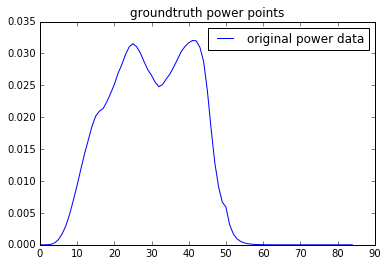

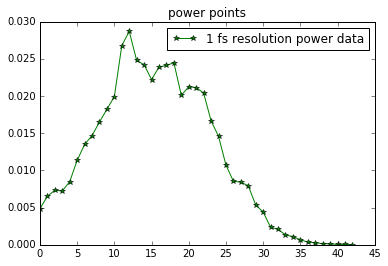

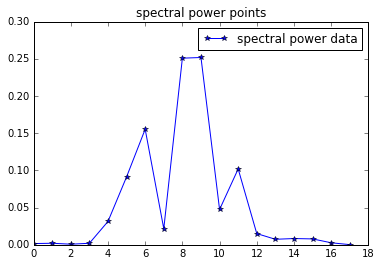

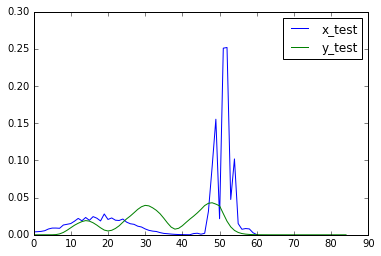

In [4]:
j=2

plt.figure()
plt.plot(y_test[j],'-',color='blue',label='original power data')
plt.title('groundtruth power points')
plt.legend(loc='upper right')

plt.figure()
plt.plot(np.array(range(temp)),x_test[j][0:temp],'-*',color='green',label='1 fs resolution power data')#,label='3fs resolution x_train data')
#plt.plot(y_test[j],'-',color='green',label='original power data')
plt.title('power points')
plt.legend(loc='upper right')

plt.figure()
plt.plot(x_train[j][temp:len(x_test[j])],'-*',label='spectral power data')
plt.title('spectral power points')
plt.legend(loc='upper right')

plt.figure()
plt.plot(x_train[j],label='x_test')
plt.plot(y_train[j],label='y_test')
plt.legend(loc='upper right')

3.2588956981e-05
0.485237276173


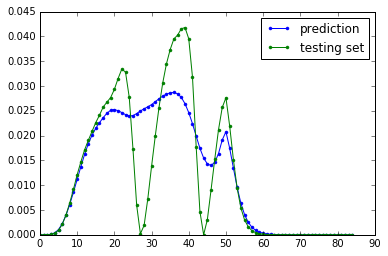

In [5]:
#scikit-learn linear regression
j=1
from sklearn.linear_model import LinearRegression
from sklearn import metrics
linreg=LinearRegression()
linreg.fit(x_train,y_train)
y_pred=linreg.predict(x_test)
print metrics.mean_squared_error(y_pred,y_test)
print np.sqrt(metrics.mean_squared_error(y_pred,y_test))/(y_test).mean()
plt.plot(range(len(y_test[0])),y_pred[j],'.-',label='prediction')
plt.plot(range(len(y_test[0])),y_test[j],'.-',label='testing set')
plt.legend(loc='upper right')

In [32]:
value=[[0.7,0.5,0.7,0.5]]
neuron=[[2000,2000,2000,2000]]#,[500,800]]
rate=[0.01]


drop=value
error={}
for n in neuron:
    for j in drop:
        for l in rate:
            #KerasRegressor
            import time

            def baseline_model():
                # create model
                model = Sequential()
                #model.add(GaussianDropout(0.05,input_shape=(25,)))
                #model.add(Dense(850, input_dim=900, kernel_initializer='normal', activation='linear'))
                model.add(Dense(n[0], input_dim=61, kernel_initializer='uniform', activation='relu'))
                model.add(Dropout(j[0]))
                model.add(Dense(n[1], activation='relu'))
                model.add(Dropout(j[1]))
                model.add(Dense(n[2], activation='relu'))
                model.add(Dropout(j[2]))
                model.add(Dense(n[3], activation='relu'))
                model.add(Dropout(j[3]))
                #model.add(Dropout(j[2]))
                #model.add(Dense(n[2], activation='relu'))
                #model.add(Dropout(j[2]))
                #model.add(Dense(100, activation='relu'))
                #model.add(Dropout(n[2]))
                model.add(Dense(85, activation='softmax'))
                #sgd = SGD(lr=l, decay=1e-8, momentum=0.9, nesterov=True)

                Ada=keras.optimizers.Adagrad(lr=l, epsilon=1e-12, decay=0.000) #0.002 for relu #5,1e-10,0 originally
                #RMS=keras.optimizers.RMSprop(lr=2, rho=0.9, epsilon=1e-10, decay=0.15)
                #model.compile(loss='mean_squared_error', optimizer=Ada,metrics=['mse'])
                model.compile(loss='categorical_crossentropy', optimizer=Ada,metrics=['mse'])
                return model

            # fix random seed for reproducibility
            seed = 7
            np.random.seed(seed)
            # evaluate model with standardized dataset
            estimator = KerasRegressor(build_fn=baseline_model, epochs=1000, batch_size=75, verbose=1)


            t_0=time.time()
            history=estimator.fit(x_train,y_train)
            t=time.time()-t_0
            print "t=%fs"%t



            for m in ['train','test']:
                if m=='train':
                    y_pred=estimator.predict(x_train)
                if m=='test':
                    y_pred=estimator.predict(x_test)



                if m=='train':
                    temp_train=np.sqrt(metrics.mean_squared_error(y_pred,y_train))/y_train.mean()
                    temp_mse=metrics.mean_squared_error(y_pred,y_train)
                if m=='test':
                    temp_test=np.sqrt(metrics.mean_squared_error(y_pred,y_test))/y_test.mean()
            error[(tuple(n),tuple(j),l)]={'train':temp_train,'mse':temp_mse,'test':temp_test,}
            print ''
            print tuple(n),tuple(j),l,temp_train,temp_test,temp_mse
for u,v in error.iteritems():
    print u,v
        #plt.plot(range(len(y_train[15])),y_pred[3],'.-',color='red',label='predict')

        #if m=='train':
        #    plt.plot(range(len(y_train[15])),y_train[3],'.-',color='blue',label='training set')
        #if m=='test':    
        #    plt.plot(range(len(y_train[15])),y_test[3],'.-',color='blue',label='testing set')

    #plt.legend(loc='upper right')

Epoch 1/1000
15000/15000 [==============================] - 2s - loss: 3.8975 - mean_squared_error: 1.2073e-04     
Epoch 2/1000
15000/15000 [==============================] - 1s - loss: 3.8079 - mean_squared_error: 6.5500e-05     
Epoch 3/1000
15000/15000 [==============================] - 1s - loss: 3.7934 - mean_squared_error: 5.8376e-05     
Epoch 4/1000
15000/15000 [==============================] - 1s - loss: 3.7881 - mean_squared_error: 5.5716e-05     
Epoch 5/1000
15000/15000 [==============================] - 1s - loss: 3.7852 - mean_squared_error: 5.4361e-05     
Epoch 6/1000
15000/15000 [==============================] - 1s - loss: 3.7829 - mean_squared_error: 5.3141e-05     
Epoch 7/1000
15000/15000 [==============================] - 1s - loss: 3.7814 - mean_squared_error: 5.2418e-05     
Epoch 8/1000
15000/15000 [==============================] - 1s - loss: 3.7800 - mean_squared_error: 5.1754e-05     
Epoch 9/1000
15000/15000 [==============================] - 1s - loss: 3

15000/15000 [==============================] - 1s - loss: 3.7467 - mean_squared_error: 3.5959e-05     
Epoch 72/1000
15000/15000 [==============================] - 1s - loss: 3.7462 - mean_squared_error: 3.5691e-05     
Epoch 73/1000
15000/15000 [==============================] - 1s - loss: 3.7462 - mean_squared_error: 3.5661e-05     
Epoch 74/1000
15000/15000 [==============================] - 1s - loss: 3.7459 - mean_squared_error: 3.5572e-05     
Epoch 75/1000
15000/15000 [==============================] - 1s - loss: 3.7460 - mean_squared_error: 3.5643e-05     
Epoch 76/1000
15000/15000 [==============================] - 1s - loss: 3.7457 - mean_squared_error: 3.5475e-05     
Epoch 77/1000
15000/15000 [==============================] - 1s - loss: 3.7457 - mean_squared_error: 3.5575e-05     
Epoch 78/1000
15000/15000 [==============================] - 1s - loss: 3.7459 - mean_squared_error: 3.5582e-05     
Epoch 79/1000
15000/15000 [==============================] - 1s - loss: 3.7458

15000/15000 [==============================] - 1s - loss: 3.7374 - mean_squared_error: 3.1598e-05     
Epoch 209/1000
15000/15000 [==============================] - 1s - loss: 3.7375 - mean_squared_error: 3.1652e-05     
Epoch 210/1000
15000/15000 [==============================] - 1s - loss: 3.7377 - mean_squared_error: 3.1747e-05     
Epoch 211/1000
15000/15000 [==============================] - 1s - loss: 3.7375 - mean_squared_error: 3.1677e-05     
Epoch 212/1000
15000/15000 [==============================] - 1s - loss: 3.7375 - mean_squared_error: 3.1689e-05     
Epoch 213/1000
15000/15000 [==============================] - 1s - loss: 3.7372 - mean_squared_error: 3.1529e-05     
Epoch 214/1000
15000/15000 [==============================] - 1s - loss: 3.7375 - mean_squared_error: 3.1675e-05     
Epoch 215/1000
15000/15000 [==============================] - 1s - loss: 3.7373 - mean_squared_error: 3.1621e-05     
Epoch 216/1000
15000/15000 [==============================] - 1s - loss

15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9464e-05     
Epoch 347/1000
15000/15000 [==============================] - 1s - loss: 3.7330 - mean_squared_error: 2.9552e-05     
Epoch 348/1000
15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9526e-05     
Epoch 349/1000
15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9470e-05     
Epoch 350/1000
15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9489e-05     
Epoch 351/1000
15000/15000 [==============================] - 1s - loss: 3.7329 - mean_squared_error: 2.9555e-05     
Epoch 352/1000
15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9470e-05     
Epoch 353/1000
15000/15000 [==============================] - 1s - loss: 3.7328 - mean_squared_error: 2.9501e-05     
Epoch 354/1000
15000/15000 [==============================] - 1s - loss

15000/15000 [==============================] - 1s - loss: 3.7303 - mean_squared_error: 2.8308e-05     
Epoch 485/1000
15000/15000 [==============================] - 1s - loss: 3.7299 - mean_squared_error: 2.8118e-05     
Epoch 486/1000
15000/15000 [==============================] - 1s - loss: 3.7299 - mean_squared_error: 2.8117e-05     
Epoch 487/1000
15000/15000 [==============================] - 1s - loss: 3.7299 - mean_squared_error: 2.8119e-05     
Epoch 488/1000
15000/15000 [==============================] - 1s - loss: 3.7301 - mean_squared_error: 2.8207e-05     
Epoch 489/1000
15000/15000 [==============================] - 1s - loss: 3.7301 - mean_squared_error: 2.8227e-05     
Epoch 490/1000
15000/15000 [==============================] - 1s - loss: 3.7302 - mean_squared_error: 2.8258e-05     
Epoch 491/1000
15000/15000 [==============================] - 1s - loss: 3.7299 - mean_squared_error: 2.8113e-05     
Epoch 492/1000
15000/15000 [==============================] - 1s - loss

15000/15000 [==============================] - 1s - loss: 3.7283 - mean_squared_error: 2.7307e-05     
Epoch 623/1000
15000/15000 [==============================] - 1s - loss: 3.7279 - mean_squared_error: 2.7136e-05     
Epoch 624/1000
15000/15000 [==============================] - 1s - loss: 3.7281 - mean_squared_error: 2.7291e-05     
Epoch 625/1000
15000/15000 [==============================] - 1s - loss: 3.7281 - mean_squared_error: 2.7167e-05     
Epoch 626/1000
15000/15000 [==============================] - 1s - loss: 3.7278 - mean_squared_error: 2.7092e-05     
Epoch 627/1000
15000/15000 [==============================] - 1s - loss: 3.7279 - mean_squared_error: 2.7164e-05     
Epoch 628/1000
15000/15000 [==============================] - 1s - loss: 3.7276 - mean_squared_error: 2.7013e-05     
Epoch 629/1000
15000/15000 [==============================] - 1s - loss: 3.7279 - mean_squared_error: 2.7112e-05     
Epoch 630/1000
15000/15000 [==============================] - 1s - loss

15000/15000 [==============================] - 1s - loss: 3.7262 - mean_squared_error: 2.6327e-05     
Epoch 761/1000
15000/15000 [==============================] - 1s - loss: 3.7264 - mean_squared_error: 2.6431e-05     
Epoch 762/1000
15000/15000 [==============================] - 1s - loss: 3.7261 - mean_squared_error: 2.6304e-05     
Epoch 763/1000
15000/15000 [==============================] - 1s - loss: 3.7260 - mean_squared_error: 2.6310e-05     
Epoch 764/1000
15000/15000 [==============================] - 1s - loss: 3.7262 - mean_squared_error: 2.6318e-05     
Epoch 765/1000
15000/15000 [==============================] - 1s - loss: 3.7262 - mean_squared_error: 2.6356e-05     
Epoch 766/1000
15000/15000 [==============================] - 1s - loss: 3.7264 - mean_squared_error: 2.6447e-05     
Epoch 767/1000
15000/15000 [==============================] - 1s - loss: 3.7261 - mean_squared_error: 2.6321e-05     
Epoch 768/1000
15000/15000 [==============================] - 1s - loss

15000/15000 [==============================] - 1s - loss: 3.7247 - mean_squared_error: 2.5622e-05     
Epoch 899/1000
15000/15000 [==============================] - 1s - loss: 3.7247 - mean_squared_error: 2.5677e-05      ETA
Epoch 900/1000
15000/15000 [==============================] - 1s - loss: 3.7247 - mean_squared_error: 2.5607e-05     
Epoch 901/1000
15000/15000 [==============================] - 1s - loss: 3.7251 - mean_squared_error: 2.5835e-05     
Epoch 902/1000
15000/15000 [==============================] - 1s - loss: 3.7250 - mean_squared_error: 2.5819e-05      E
Epoch 903/1000
15000/15000 [==============================] - 1s - loss: 3.7248 - mean_squared_error: 2.5685e-05     
Epoch 904/1000
15000/15000 [==============================] - 1s - loss: 3.7247 - mean_squared_error: 2.5618e-05     
Epoch 905/1000
15000/15000 [==============================] - 1s - loss: 3.7246 - mean_squared_error: 2.5577e-05     
Epoch 906/1000
15000/15000 [==============================] - 1s 

In [34]:
#save model
value=[[0.5,0.5,0.5,0.5]]
neuron=[[2000,2000,2000,2000]]
rate=[0.01]

from keras.models import load_model
#(estimator.model).save('0322_1_neurons:'+str(neuron[0])+'_dropout:'+str(value[0])+'_rate:'+str(rate[0])+'_model.h5')  # creates a HDF5 file
del estimator.model  # deletes the existing model
estimator.model = load_model('neurons:'+str(neuron[0])+'_dropout:'+str(value[0])+'_rate:'+str(rate[0])+'_model.h5')
#estimator.model = load_model('neurons:'+str(neuron[0])+'_dropout:'+str(value[0])+'_rate:'+str(rate[0])+'_model.h5')


#history.history.keys()
#plt.plot(history.history['mean_squared_error'])
#plt.xlabel("epochs")
#plt.ylabel("mse")

IOError: Unable to open file (Unable to open file: name = 'neurons:[2000, 2000, 2000, 2000]_dropout:[0.5, 0.5, 0.5, 0.5]_rate:0.01_model.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

14700/15000 [============================>.] - ETA: 0s

training error 0.33436893091

4050/5000 [=======================>......] - ETA: 0s
testing error 0.428868805872



time consumed:0.556912899017


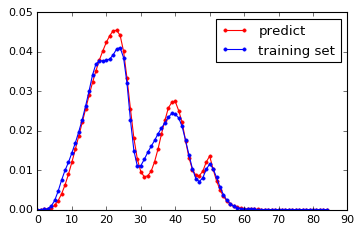

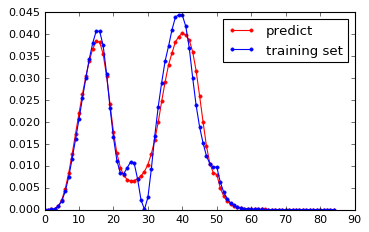

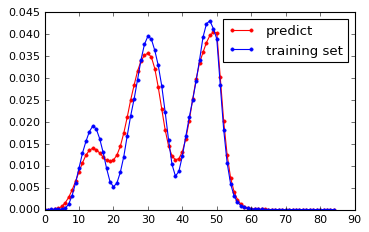

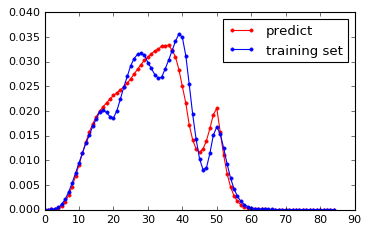

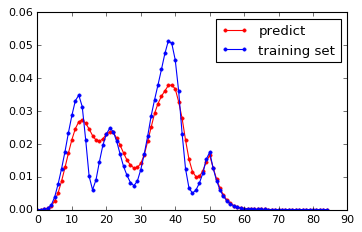

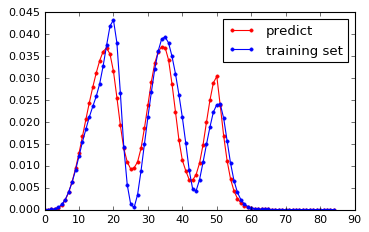

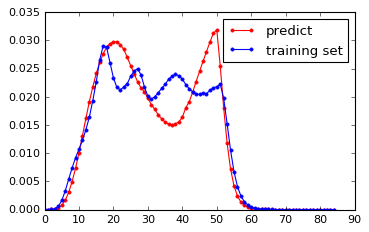

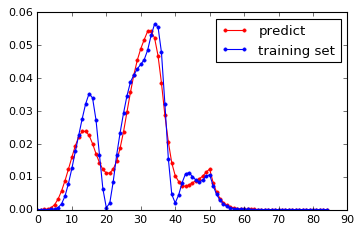

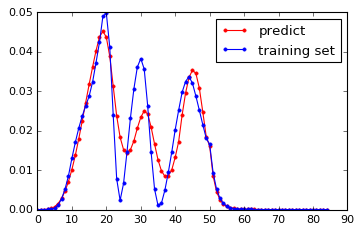

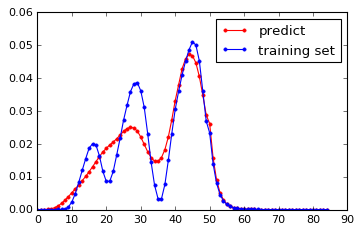

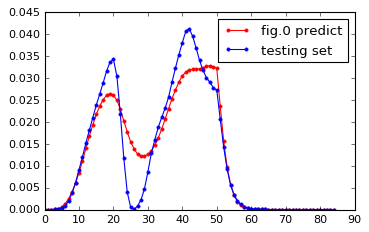

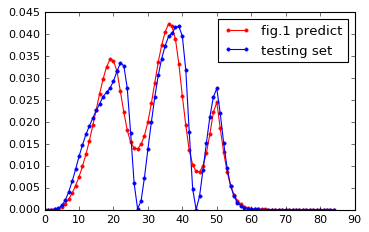

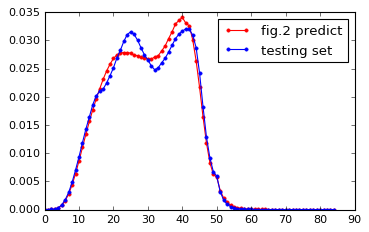

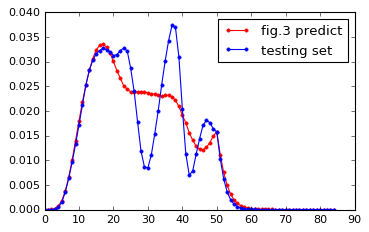

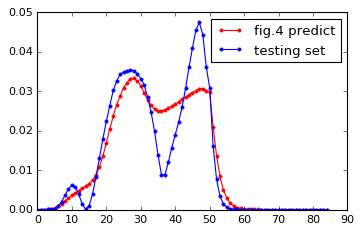

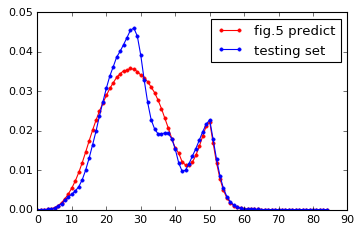

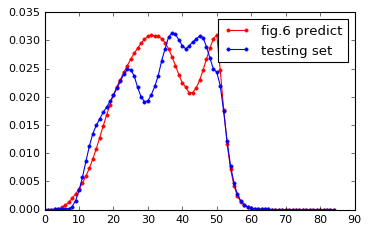

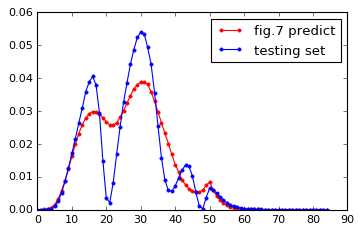

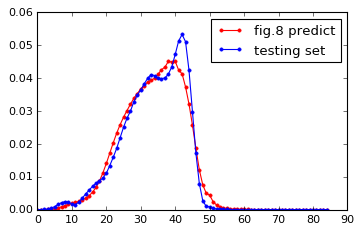

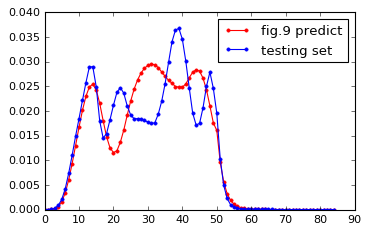

In [29]:
import time
from sklearn.linear_model import LinearRegression
from sklearn import metrics
count=0
time_consumed=0
for m in ['train','test']:        
    tic=time.time()
    if m=='train':
        y_pred=estimator.predict(x_train)
    print ''
    if m=='test':
        y_pred=estimator.predict(x_test)
    toc=time.time()
    time_consumed+=toc-tic
        
    print ''
    if m=='train':
        if count==0:
            print 'training error', np.sqrt(metrics.mean_squared_error(y_pred,y_train))/y_train.mean()
        count+=1
    if m=='test':
        print 'testing error', np.sqrt(metrics.mean_squared_error(y_pred,y_test))/y_test.mean()
            #print 'reconstructed error', np.sqrt(metrics.mean_squared_error(recon,y_test))/y_test.mean()
        count+=1
        print ''
        print ''
        print ''

    for i in range(10):
        plt.figure(figsize=(5,7), dpi=80)
        if m=='train':
            plt.subplot(211)
            plt.plot(range(len(y_train[15])),y_pred[i],'.-',color='red',label='predict')
            plt.plot(range(len(y_train[15])),y_train[i],'.-',color='blue',label='training set')
            plt.legend(loc='upper right')
        if m=='test': 
            plt.subplot(212)
            plt.plot(range(len(y_test[0])),y_pred[i],'.-',color='red',label='fig.'+str(i)+' predict')
            plt.plot(range(len(y_test[0])),y_test[i],'.-',color='blue',label='testing set')
            #plt.plot(range(len(y_test[15])),recon[i],'.-',color='black',label='reconstructed data')
            plt.legend(loc='upper right')

print "time consumed:"+str(time_consumed)